# Aprendizaje Profundo - Clase 3  - Custom Loss


In [4]:
# Importo librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Cargamos el dataset

In [5]:
# Carga del dataset
df = pd.read_csv("..\..\clase_3\data\class_7_wine_dataset_v2.csv")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Trabajo AP/Material/class_7_wine_dataset_v2.csv'

In [ ]:
# Type es tipo categórica, transformamos con One Hot Encoding
type_dummies = pd.get_dummies(df['type'], prefix="type")
type_dummies
df = pd.concat([df,type_dummies], axis = 1)

In [ ]:
# Transformamos quality a quality label
df["quality_label"] = df["quality"].apply(lambda q:0 if q<=6 else 1)

In [ ]:
# Como tenemos pocos nan, borramos las filas donde hay nan y trabajamos con un dataset completo
ds = df[df.isna().sum(axis = 1) == 0]

<Axes: >

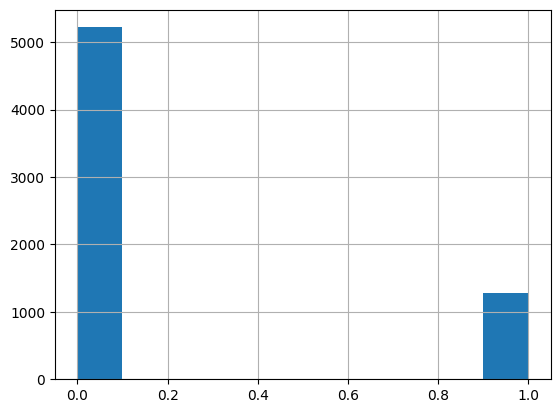

In [ ]:
# El dataset está desbalanceado hacia los vinos "malos"
df["quality_label"].hist()

## Armado del dataset

In [ ]:
# Recordar que debo borrar del dataset de entrada mi columna de salida!
x = ds.drop(['Unnamed: 0','type','vendor_id','quality','quality_label'], axis=1) 
y = ds['quality_label']

## Normalizacion

Las redes neuronales no requieren que los datos esten normalizados, pero la normalización ayuda a que el algoritmo de gradient descent converga más rápido.

In [ ]:
# Convierto a numpy
x = x.to_numpy()
y = y.to_numpy()
# Normalización min max
x_norm = (x - np.min(x, axis=0)) / (np.max(x, axis=0 ) - np.min(x, axis=0))

## División del dataset
Divido en entrenamiento y validación

In [ ]:
idx = np.random.permutation(x_norm.shape[0])
train_idx = idx[0:int(0.85*len(idx))]
valid_idx = idx[int(0.85*len(idx)):]

In [ ]:
train_x = x_norm[train_idx]
train_y = y[train_idx]
valid_x = x_norm[valid_idx]
valid_y = y[valid_idx]

n_train = train_x.shape[0]
n_valid = valid_x.shape[0]

## Pytorch

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn import metrics

In [ ]:
device = "cpu"
if torch.cuda.is_available():
  device = "cuda:0"

device

'cpu'

In [3]:
# Pytorch necesita de una clase de dataset que extienda de torch.utils.data.Dataset
# Esta clase dataset debe sobreescribir los métodos init, len y getitem
class MyDataset(Dataset):

  #__init__ guarda el dataset en una variable de clase
  def __init__(self, x, y):
    self.x = torch.from_numpy(x.astype('float'))  ## Modif JP
    self.y = torch.from_numpy(y.astype('float'))  ## Modif JP

  # __len__ define el comportamiento de la función len() sobre el objeto
  def __len__(self):
    return self.x.shape[0]

  # __getitem__ define el comportamiento de los []
  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

NameError: name 'Dataset' is not defined

In [ ]:
# Creo el dataset de entrenamiento
train_ds = MyDataset(train_x, train_y)
# Creo el dataset de validación
valid_ds = MyDataset(valid_x, valid_y)

# Pytorch utiliza DataLoader para entregar los dataset de a batches
train_dataloader = DataLoader(train_ds, batch_size = 64, shuffle= True)
valid_dataloader = DataLoader(valid_ds, batch_size=64)

#### Entrenamiento con loss estándar (BinaryCrossEntropy)

In [ ]:
# Arquitectura red neuronal
class NNet(torch.nn.Module):

  def __init__(self):
    # Defino la arquitectura de la red
    super().__init__()
    self.linear_1 = torch.nn.Linear(in_features=13, out_features=200, bias=True)
    self.relu_1 = torch.nn.ReLU()
    self.linear_2 = torch.nn.Linear(in_features = 200, out_features=100, bias=True)
    self.relu_2 = torch.nn.ReLU()
    self.linear_3 = torch.nn.Linear(in_features = 100, out_features= 1, bias=True)
    self.output = torch.nn.Sigmoid()

  def forward(self, x):
    # Defino el cálculo del paso forward
    x = self.linear_1(x)
    x = self.relu_1(x)
    x = self.linear_2(x)
    x = self.relu_2(x)
    x = self.linear_3(x)
    x = self.output(x)
    return x

In [ ]:
# Instanciamos la red
nnet = NNet()
# Copio la red neuronal al dispositivo donde entrene la red neuronal
nnet = nnet.to(device)
# Loss
loss_function = torch.nn.BCELoss(reduction='sum')
# Optimizer
optimizer = torch.optim.Adam(nnet.parameters(), lr=0.0001)

In [ ]:
# cantidad de epochs
epochs = 100

# Doble loop algoritmo Mini-Batch
for epoch in range(epochs):
  
  ############################################
  ## Entrenamiento
  ############################################
  nnet.train(True)

  epoch_loss = 0
  epoch_y_hat = []
  epoch_y = []
  
  for i,data in enumerate(train_dataloader):
    # Obtengo los datos del batch de entrenamiento
    x_batch, y_batch = data
    # Copio el batch al dispositivo donde entreno la red neuronal
    x_batch = x_batch.to(device).float()
    y_batch = y_batch.to(device).float().reshape(-1, 1)

    # Paso forward
    # Limpio optimizer para empezar un nuevo cálculo de gradiente
    optimizer.zero_grad()
    y_batch_hat = nnet(x_batch)
    
    # Calculo el loss
    loss = loss_function(y_batch_hat, y_batch)

    # Backpropagation
    loss.backward()

    # Actualizar los parámetros
    optimizer.step()

    # Almaceno los valores reales y mis predicciones para cálcular las métricas
    epoch_y += list(y_batch.detach().cpu().numpy())
    epoch_y_hat += list(y_batch_hat.detach().cpu().numpy())
    # Acumulo la loss del batch
    epoch_loss = epoch_loss + loss.item()

  # Calculo la media de la loss
  epoch_loss = epoch_loss / n_train
  # Cálculo la métrica de la epoch
  accuracy = metrics.accuracy_score(epoch_y, [j>=0.5 for j in epoch_y_hat])
  recall = metrics.recall_score(epoch_y, [j>=0.5 for j in epoch_y_hat])

  ############################################
  ## Validación
  ############################################
  # Desactivo el cálculo de gradiente para validación
  nnet.train(False)

  valid_epoch_loss = 0
  valid_epoch_y_hat = []
  valid_epoch_y = []

  for i,data in enumerate(valid_dataloader):
    # Obtengo los datos del batch de validación
    x_batch, y_batch = data
    # Copio el batch al dispositivo donde entreno la red neuronal
    x_batch = x_batch.to(device).float()
    y_batch = y_batch.to(device).float().reshape(-1, 1)

    # Paso forward
    y_batch_hat = nnet(x_batch)
    
    # Calculo el loss
    loss = loss_function(y_batch_hat, y_batch)

    # En validación no hago backpropagation!!

    # Almaceno los valores reales y mis predicciones para cálcular las métricas
    valid_epoch_y += list(y_batch.detach().cpu().numpy())
    valid_epoch_y_hat += list(y_batch_hat.detach().cpu().numpy())
    # Acumulo la loss del batch
    valid_epoch_loss = valid_epoch_loss + loss.item()

  # Calculo la media de la loss
  valid_epoch_loss = valid_epoch_loss / n_valid
  # Cálculo la métrica de la epoch
  valid_accuracy = metrics.accuracy_score(valid_epoch_y, [j>=0.5 for j in valid_epoch_y_hat])
  valid_recall = metrics.recall_score(valid_epoch_y, [j>=0.5 for j in valid_epoch_y_hat])

  ############################################
  ## Impresión de resultados por epoch
  ############################################
  print(f" Epoch {epoch} | " \
        f"Train/Valid loss: {epoch_loss:.3f} / {valid_epoch_loss:.3f} | " \
        f"Train/Valid accuracy: {accuracy:.3f} / {valid_accuracy:.3f} | " \
        f"Train/Valid recall: {recall:.3f} / {valid_recall:.3f} | ")

 Epoch 0 | Train/Valid loss: 0.650 / 0.594 | Train/Valid accuracy: 0.703 / 0.787 | Train/Valid recall: 0.147 / 0.000 | 
 Epoch 1 | Train/Valid loss: 0.538 / 0.522 | Train/Valid accuracy: 0.806 / 0.787 | Train/Valid recall: 0.000 / 0.000 | 
 Epoch 2 | Train/Valid loss: 0.491 / 0.509 | Train/Valid accuracy: 0.806 / 0.787 | Train/Valid recall: 0.000 / 0.000 | 
 Epoch 3 | Train/Valid loss: 0.479 / 0.501 | Train/Valid accuracy: 0.806 / 0.787 | Train/Valid recall: 0.000 / 0.000 | 
 Epoch 4 | Train/Valid loss: 0.469 / 0.490 | Train/Valid accuracy: 0.806 / 0.787 | Train/Valid recall: 0.000 / 0.000 | 
 Epoch 5 | Train/Valid loss: 0.460 / 0.481 | Train/Valid accuracy: 0.806 / 0.787 | Train/Valid recall: 0.000 / 0.000 | 
 Epoch 6 | Train/Valid loss: 0.450 / 0.470 | Train/Valid accuracy: 0.806 / 0.787 | Train/Valid recall: 0.000 / 0.000 | 
 Epoch 7 | Train/Valid loss: 0.440 / 0.460 | Train/Valid accuracy: 0.806 / 0.787 | Train/Valid recall: 0.000 / 0.000 | 
 Epoch 8 | Train/Valid loss: 0.431 / 0.4

Si bien el accuracy es alto, el recall (que mide el porcentaje de vinos buenos clasificados como buenos) es muy bajo. Esto se debe al desbalance entre las clases 

#### Entrenamiento con loss custom

In [ ]:
# La función de costo custom se define como la red neuronal, extendiendo la 
# clase torch.nn.Module
class CustomLoss(torch.nn.Module):

  def __init__(self):
    super().__init__()
    self.criterion = torch.nn.BCELoss()
    pass

  # En el paso forward se aplica el algoritmo de la función de perdida
  # y se retorna el valor escalar de pérdida.
  def forward(self, output, target):
    bce = self.criterion(output, target)
    tp = (output * target).sum()
    fn = ((1- output) * target).sum()
    recall = tp / ((tp + fn))
    return bce - recall

La loss anterior es inventada, es una mezcla de BinaryCrossEntropy y una aproximación con derivada continua del recall. 

El signo menos antes del recall en el cálculo de la pérdida es porque el algoritmo de optimización busca minimizar la función de pérdida, pero nosotros deseamos maximizar el recall.

In [ ]:
# Instanciamos la red
nnet = NNet()
# Copio la red neuronal al dispositivo donde entrene la red neuronal
nnet = nnet.to(device)
# Loss custom
loss_function = CustomLoss()
# Optimizer
optimizer = torch.optim.Adam(nnet.parameters(), lr=0.0001)

In [ ]:
# cantidad de epochs
epochs = 100

# Doble loop algoritmo Mini-Batch
for epoch in range(epochs):
  
  ############################################
  ## Entrenamiento
  ############################################
  nnet.train(True)

  epoch_loss = 0
  epoch_y_hat = []
  epoch_y = []
  
  for i,data in enumerate(train_dataloader):
    # Obtengo los datos del batch de entrenamiento
    x_batch, y_batch = data
    # Copio el batch al dispositivo donde entreno la red neuronal
    x_batch = x_batch.to(device).float()
    y_batch = y_batch.to(device).float().reshape(-1, 1)

    # Paso forward
    # Limpio optimizer para empezar un nuevo cálculo de gradiente
    optimizer.zero_grad()
    y_batch_hat = nnet(x_batch)
    
    # Calculo el loss
    loss = loss_function(y_batch_hat, y_batch)

    # Backpropagation
    loss.backward()

    # Actualizar los parámetros
    optimizer.step()

    # Almaceno los valores reales y mis predicciones para cálcular las métricas
    epoch_y += list(y_batch.detach().cpu().numpy())
    epoch_y_hat += list(y_batch_hat.detach().cpu().numpy())
    # Acumulo la loss del batch
    epoch_loss = epoch_loss + loss.item()

  # Calculo la media de la loss
  epoch_loss = epoch_loss / n_train
  # Cálculo la métrica de la epoch
  accuracy = metrics.accuracy_score(epoch_y, [j>=0.5 for j in epoch_y_hat])
  recall = metrics.recall_score(epoch_y, [j>=0.5 for j in epoch_y_hat])

  ############################################
  ## Validación
  ############################################
  # Desactivo el cálculo de gradiente para validación
  nnet.train(False)

  valid_epoch_loss = 0
  valid_epoch_y_hat = []
  valid_epoch_y = []

  for i,data in enumerate(valid_dataloader):
    # Obtengo los datos del batch de validación
    x_batch, y_batch = data
    # Copio el batch al dispositivo donde entreno la red neuronal
    x_batch = x_batch.to(device).float()
    y_batch = y_batch.to(device).float().reshape(-1, 1)

    # Paso forward
    y_batch_hat = nnet(x_batch)
    
    # Calculo el loss
    loss = loss_function(y_batch_hat, y_batch)

    # En validación no hago backpropagation!!

    # Almaceno los valores reales y mis predicciones para cálcular las métricas
    valid_epoch_y += list(y_batch.detach().cpu().numpy())
    valid_epoch_y_hat += list(y_batch_hat.detach().cpu().numpy())
    # Acumulo la loss del batch
    valid_epoch_loss = valid_epoch_loss + loss.item()

  # Calculo la media de la loss
  valid_epoch_loss = valid_epoch_loss / n_valid
  # Cálculo la métrica de la epoch
  valid_accuracy = metrics.accuracy_score(valid_epoch_y, [j>=0.5 for j in valid_epoch_y_hat])
  valid_recall = metrics.recall_score(valid_epoch_y, [j>=0.5 for j in valid_epoch_y_hat])

  ############################################
  ## Impresión de resultados por epoch
  ############################################
  print(f" Epoch {epoch} | " \
        f"Train/Valid loss: {epoch_loss:.3f} / {valid_epoch_loss:.3f} | " \
        f"Train/Valid accuracy: {accuracy:.3f} / {valid_accuracy:.3f} | " \
        f"Train/Valid recall: {recall:.3f} / {valid_recall:.3f} | ")

 Epoch 0 | Train/Valid loss: 0.003 / 0.003 | Train/Valid accuracy: 0.553 / 0.800 | Train/Valid recall: 0.562 / 0.063 | 
 Epoch 1 | Train/Valid loss: 0.003 / 0.003 | Train/Valid accuracy: 0.809 / 0.787 | Train/Valid recall: 0.175 / 0.353 | 
 Epoch 2 | Train/Valid loss: 0.002 / 0.002 | Train/Valid accuracy: 0.777 / 0.759 | Train/Valid recall: 0.482 / 0.541 | 
 Epoch 3 | Train/Valid loss: 0.001 / 0.001 | Train/Valid accuracy: 0.745 / 0.744 | Train/Valid recall: 0.598 / 0.585 | 
 Epoch 4 | Train/Valid loss: 0.000 / -0.000 | Train/Valid accuracy: 0.739 / 0.742 | Train/Valid recall: 0.648 / 0.623 | 
 Epoch 5 | Train/Valid loss: -0.000 / -0.001 | Train/Valid accuracy: 0.745 / 0.753 | Train/Valid recall: 0.665 / 0.614 | 
 Epoch 6 | Train/Valid loss: -0.001 / -0.001 | Train/Valid accuracy: 0.747 / 0.745 | Train/Valid recall: 0.670 / 0.681 | 
 Epoch 7 | Train/Valid loss: -0.001 / -0.001 | Train/Valid accuracy: 0.749 / 0.757 | Train/Valid recall: 0.691 / 0.662 | 
 Epoch 8 | Train/Valid loss: -0.0

El accuracy es menor (lo cual es esperable ya que estamos imponiendo restricciones adicionales a la función de costo) pero se logró un recall marcadamente mayor.

Con que modelo nos quedamos depende de las necesidades del problema.